# Webscrapping -  ETL Design

## Imports

In [24]:
import re
import sqlite3
import requests
import numpy  as np
import pandas as pd

from bs4             import BeautifulSoup
from datetime        import datetime
from sqlalchemy      import create_engine
from IPython.display import Image

## Data Collection

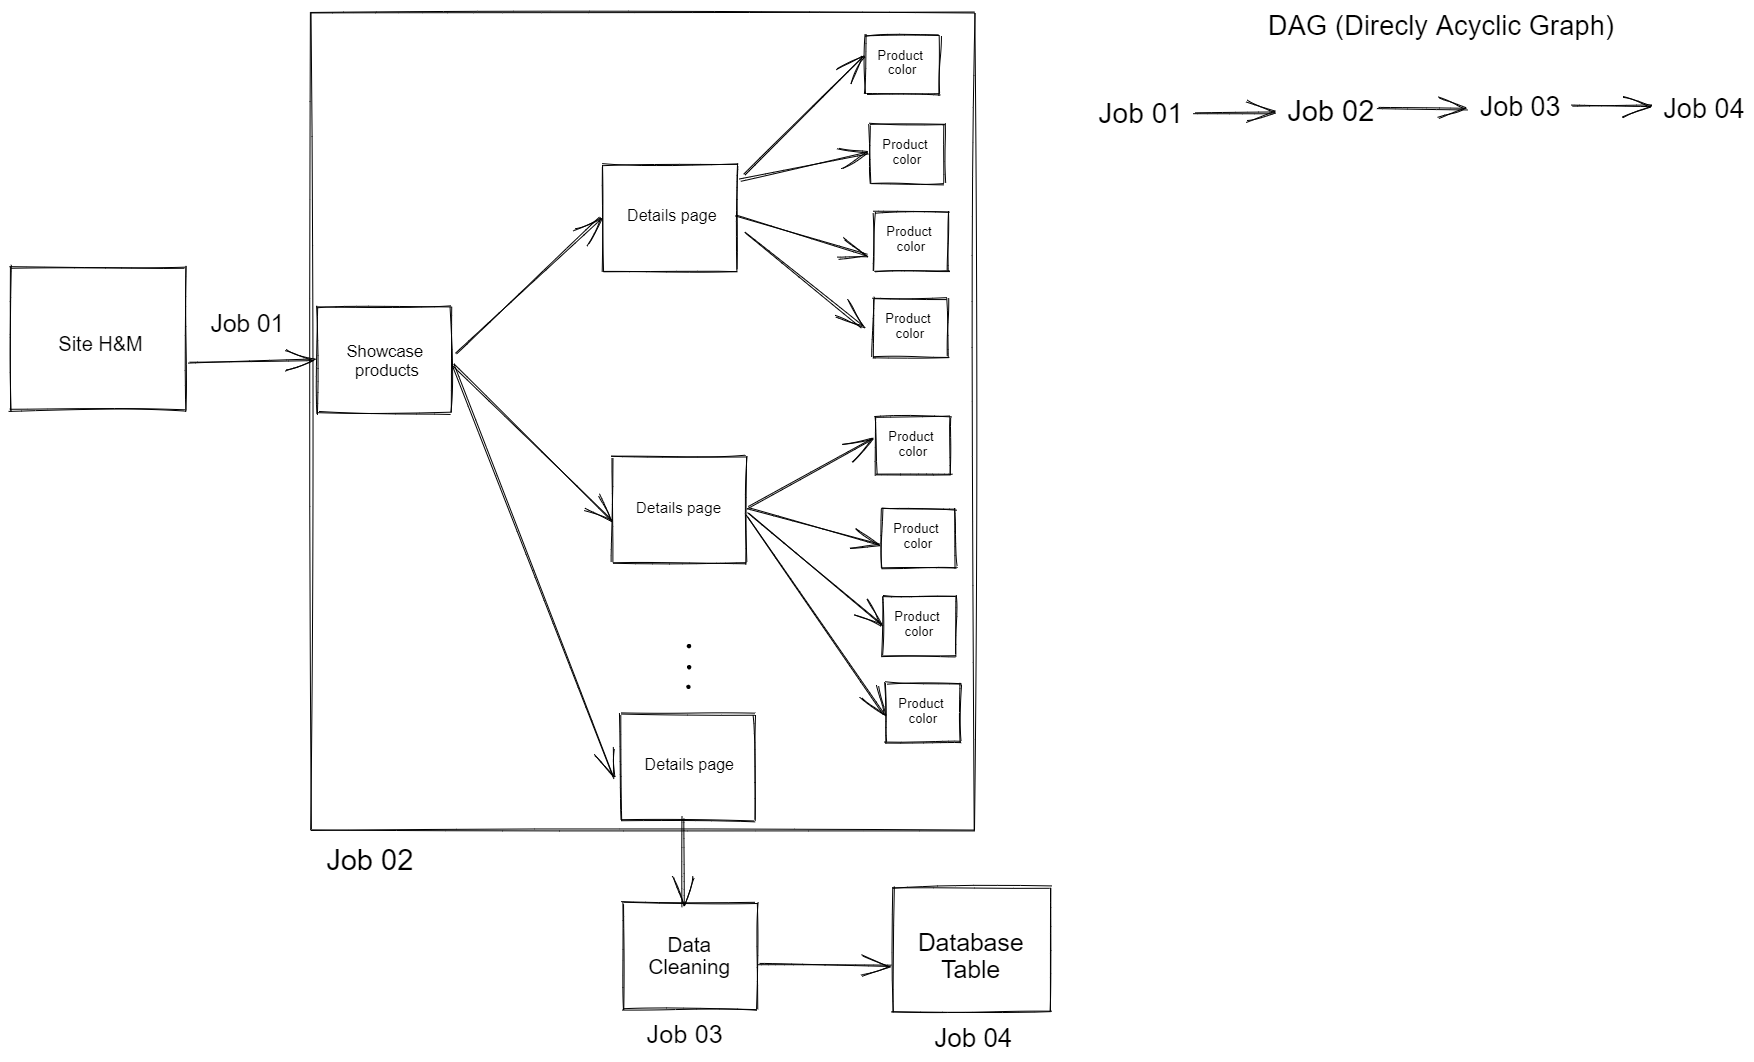

In [25]:
Image('/mnt/c/Users/debor/repos/Male-Jeans-Price/img/DAG.png')

In [2]:
# parameters
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

# URL
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

# REQUEST TO URL
page = requests.get(url, headers=headers)

# BeautifulSoup object
soup = BeautifulSoup(page.text, 'html.parser')

# =============================== Products Data ===========================
products = soup.find('ul', class_='products-listing small')
product_list = products.find_all('article', class_='hm-product-item')

# product_id
product_id = [p.get('data-articlecode') for p in product_list]

# product_type
product_category = [p.get('data-category') for p in product_list]

product_list = products.find_all('a', class_='link')

# product name
product_name = [p.get_text() for p in product_list]

# price
product_list = products.find_all('span', class_='price regular')
product_price = [p.get_text() for p in product_list]

data = pd.DataFrame([product_id, product_category, product_name, product_price]).T
data.columns = ['product_id', 'product_category', 'product_name', 'product_price']

## Data Collection by Product

In [3]:
# empty dataframe
df_compositions = pd.DataFrame()

# # initialize unique columns for all products
aux = []

df_pattern = pd.DataFrame(columns=['Art. No.', 'Composition', 'Fit', 'More sustainable materials', 'Product safety', 'Size'])

for i in range(len(data)):
    # API requests
    url = 'https://www2.hm.com/en_us/productpage.' + data.loc[i, 'product_id'] + '.html'
    print('Product: {}'.format(url))
    
    page = requests.get(url, headers=headers)

    # BeautifulSoup object
    soup = BeautifulSoup(page.text, 'html.parser')

    # ======================= color name ==============================    
    product_list = soup.find_all('a', class_=['filter-option miniature active', 'filter-option miniature'])
    
    color_name = [p.get('data-color') for p in product_list]
    
    # NOTE: IT GETS PRODUCTS WHICH ARE NOT IN THE MINISLIDER SHOWCASE
    #       by consequence, for each product it does the same
    #       so each product is catched multiple times in different showcases

    # product_id
    product_id = [p.get('data-articlecode') for p in product_list]

    df_color = pd.DataFrame([product_id, color_name]).T
    df_color.columns = ['product_id', 'color_name']
    
    
    # compositions by color
    for j in range(len(df_color)):
        
        # API requests
        url = 'https://www2.hm.com/en_us/productpage.' + df_color.loc[j, 'product_id'] + '.html'
        print('Color: {}'.format(url))

        page = requests.get(url, headers=headers)

        # BeautifulSoup object
        soup = BeautifulSoup(page.text, 'html.parser')
        
        # ======================= Product Name ===============================
        product_name = soup.find_all('h1', class_='primary product-item-headline')[0].get_text()
        
        
        # ======================= Product Price ===============================
        product_price = soup.find_all('div', class_='primary-row product-item-price')
    
        product_price = re.findall(r'\d+\.?\d+', product_price[0].get_text())[0]        
        

        # ======================= composition ===============================
        product_composition_list = soup.find_all('div', class_='pdp-description-list-item')
        product_composition = [list(filter(None, p.get_text().split('\n'))) for p in product_composition_list]

        # rename dataframe
        df_composition = pd.DataFrame(product_composition).T
        df_composition.columns = df_composition.iloc[0]

        # delete first row
        df_composition = df_composition.iloc[1:].fillna(method='ffill')

        # Note: the Pocket composition could be remoded here, however its composition would remain in the dataframe

        # ensure same number of columns
        df_composition = pd.concat([df_pattern, df_composition], axis=0)

        # rename columns
        df_composition.columns = ['product_id', 'composition', 'fit', 'more_sustainable_materials', 'product_safety', 'size']
        
        # append product name and price columns
        df_composition['product_name'] = product_name
        df_composition['product_price'] = product_price

        # if there is any other column, save in this auxiliar dataframe
        aux = aux + df_composition.columns.tolist()

        # merge df_composition + df_color
        df_composition = pd.merge(df_composition, df_color, how='left', on='product_id')

        # Color and composition for all products
        df_compositions = pd.concat([df_compositions, df_composition], axis=0)
    
    
# Merge Showcase data + details

# define style id
df_compositions['style_id'] = df_compositions['product_id'].apply(lambda x: x[:-3])
df_compositions['color_id'] = df_compositions['product_id'].apply(lambda x: x[-3:])

# scrapy datetime
df_compositions['scrapy_datetime'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')


Product: https://www2.hm.com/en_us/productpage.0690449051.html
Color: https://www2.hm.com/en_us/productpage.0690449001.html
Color: https://www2.hm.com/en_us/productpage.0690449002.html
Color: https://www2.hm.com/en_us/productpage.0690449006.html
Color: https://www2.hm.com/en_us/productpage.0690449007.html
Color: https://www2.hm.com/en_us/productpage.0690449009.html
Color: https://www2.hm.com/en_us/productpage.0690449011.html
Color: https://www2.hm.com/en_us/productpage.0690449013.html
Color: https://www2.hm.com/en_us/productpage.0690449021.html
Color: https://www2.hm.com/en_us/productpage.0690449022.html
Color: https://www2.hm.com/en_us/productpage.0690449024.html
Color: https://www2.hm.com/en_us/productpage.0690449028.html
Color: https://www2.hm.com/en_us/productpage.0690449035.html
Color: https://www2.hm.com/en_us/productpage.0690449036.html
Color: https://www2.hm.com/en_us/productpage.0690449040.html
Color: https://www2.hm.com/en_us/productpage.0690449043.html
Color: https://www2.hm

Color: https://www2.hm.com/en_us/productpage.0690449036.html
Color: https://www2.hm.com/en_us/productpage.0690449040.html
Color: https://www2.hm.com/en_us/productpage.0690449043.html
Color: https://www2.hm.com/en_us/productpage.0690449046.html
Color: https://www2.hm.com/en_us/productpage.0690449051.html
Product: https://www2.hm.com/en_us/productpage.0690449043.html
Color: https://www2.hm.com/en_us/productpage.0690449001.html
Color: https://www2.hm.com/en_us/productpage.0690449002.html
Color: https://www2.hm.com/en_us/productpage.0690449006.html
Color: https://www2.hm.com/en_us/productpage.0690449007.html
Color: https://www2.hm.com/en_us/productpage.0690449009.html
Color: https://www2.hm.com/en_us/productpage.0690449011.html
Color: https://www2.hm.com/en_us/productpage.0690449013.html
Color: https://www2.hm.com/en_us/productpage.0690449021.html
Color: https://www2.hm.com/en_us/productpage.0690449022.html
Color: https://www2.hm.com/en_us/productpage.0690449024.html
Color: https://www2.hm

Color: https://www2.hm.com/en_us/productpage.0811993025.html
Color: https://www2.hm.com/en_us/productpage.0811993028.html
Color: https://www2.hm.com/en_us/productpage.0811993031.html
Color: https://www2.hm.com/en_us/productpage.0811993034.html
Color: https://www2.hm.com/en_us/productpage.0811993036.html
Color: https://www2.hm.com/en_us/productpage.0811993037.html
Product: https://www2.hm.com/en_us/productpage.1004476002.html
Color: https://www2.hm.com/en_us/productpage.1004476001.html
Color: https://www2.hm.com/en_us/productpage.1004476002.html
Color: https://www2.hm.com/en_us/productpage.1004476003.html
Color: https://www2.hm.com/en_us/productpage.1004476004.html
Color: https://www2.hm.com/en_us/productpage.1004476005.html
Product: https://www2.hm.com/en_us/productpage.0985159004.html
Color: https://www2.hm.com/en_us/productpage.0985159001.html
Color: https://www2.hm.com/en_us/productpage.0985159002.html
Color: https://www2.hm.com/en_us/productpage.0985159003.html
Color: https://www2.

## Data Cleaning

In [6]:
df_data = df_compositions.copy()

# product id
df_data = df_data.dropna(subset=['product_id'])

# product name
df_data['product_name'] = df_data['product_name'].str.replace('\n', '').str.replace('\t', '')
df_data['product_name'] = df_data['product_name'].str.replace('  ', '').str.replace(' ', '_').str.lower()

# product price
df_data['product_price'] = df_data['product_price'].astype(float)

# color name
df_data['color_name'] = df_data['color_name'].str.replace(' ', '_').str.replace('-', '_').str.lower()

# fit
df_data['fit'] = df_data['fit'].str.replace(' ', '_').str.lower()

# size number -> model height
df_data['size_number'] = df_data['size'].apply(lambda x: re.search('\d{3}cm', x).group(0) if pd.notnull(x) else x)
df_data['size_number'] = df_data['size_number'].apply(lambda x: re.search('\d+', x).group(0) if pd.notnull(x) else x)

# size model -> model clothing size
df_data['size_model'] = df_data['size'].str.extract('(\d+/\\d+)')


# ========================== composition ====================================

# lines refering to the pocket composition were eliminated
df_data = df_data[~df_data['composition'].str.contains('Pocket lining: ', na=False)]
df_data = df_data[~df_data['composition'].str.contains('Lining: ', na=False)]
df_data = df_data[~df_data['composition'].str.contains('Pocket: ', na=False)]

# editing strings which contain shell word
df_data['composition'] = df_data['composition'].apply(lambda x: x.replace('Shell: ', '') if pd.notnull(x) else x)


# break composition by comma
df1 = df_data['composition'].str.split(',', expand=True).reset_index(drop=True)
df1 = df1.fillna(value=np.nan)

# ===============

'''
IMPORTANT NOTE: what are the materials in each column of df1?
    0 - Cotton
    1 - Elastane, Elasterell-P, Polyester
    2 - Elastane, Modal, Viscose
    3 - Elastane
'''

# cotton | polyester | elastane | elasterell
df_ref = pd.DataFrame(index=np.arange(len(df_data)), columns=['cotton', 'polyester', 'elastane','elasterell', 'modal'])

# ---------- cotton ------------
df_cotton = df1[0]
df_cotton.name = 'cotton'

df_ref = pd.concat([df_ref, df_cotton], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep='last')]
# df_ref['cotton'] = df_ref['cotton'].fillna('Cotton 0%')

# ----------- polyester -----------
df_polyester = df1.loc[df1[1].str.contains('Polyester', na=True), 1]
df_polyester.name = 'polyester'

df_ref = pd.concat([df_ref, df_polyester], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep='last')]
# df_ref['polyester'] = df_ref['polyester'].fillna('Polyester 0%')

# ----------- elastane -----------
# elastane1
df_elastane_1 = df1.loc[df1[1].str.contains('Elastane', na=True), 1]
df_elastane_1.name = 'elastane'

# elastane2
df_elastane_2 = df1.loc[df1[2].str.contains('Elastane', na=True), 2]
df_elastane_2.name = 'elastane'

# elastane3
df_elastane_3 = df1.loc[df1[3].str.contains('Elastane', na=True), 3]
df_elastane_3.name = 'elastane'

# combine elastane 1 + 2 + 3
df_elastane_12 = df_elastane_1.combine_first(df_elastane_2)
df_elastane = df_elastane_12.combine_first(df_elastane_3)

df_ref = pd.concat([df_ref, df_elastane], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep='last')]
# df_ref['elastane'] = df_ref['elastane'].fillna('Elastane 0%')

# ----------- elasterell -----------
df_elasterell = df1.loc[df1[1].str.contains('Elasterell', na=True), 1]
df_elasterell.name = 'elasterell'

df_ref = pd.concat([df_ref, df_elasterell], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep='last')]
# df_ref['elasterell'] = df_ref['elasterell'].fillna('Elasterell-P 0%')

# ----------- modal -----------
df_modal = df1.loc[df1[2].str.contains('Modal', na=True), 2]
df_modal.name = 'modal'

df_ref = pd.concat([df_ref, df_modal], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep='last')]
# df_ref['modal'] = df_ref['modal'].fillna('modal-P 0%')

# reset df_ref index by product_id
df_aux = pd.concat([df_data['product_id'].reset_index(drop=True), df_ref], axis=1)

# format composition data
df_aux['cotton']     = df_aux['cotton'].apply(lambda x: int(re.search('\d+', x).group(0))/100 if pd.notnull(x) else x)
df_aux['elastane']   = df_aux['elastane'].apply(lambda x: int(re.search('\d+', x).group(0))/100 if pd.notnull(x) else x)
df_aux['polyester']  = df_aux['polyester'].apply(lambda x: int(re.search('\d+', x).group(0))/100 if pd.notnull(x) else x)
df_aux['elasterell'] = df_aux['elasterell'].apply(lambda x: int(re.search('\d+', x).group(0))/100 if pd.notnull(x) else x)
df_aux['modal']      = df_aux['modal'].apply(lambda x: int(re.search('\d+', x).group(0))/100 if pd.notnull(x) else x)


# # ==================== more sustainable materials ---------------> NOT CONSIDERED FOR NOW
# df_data['recicled_cotton'] = df_data['more_sustainable_materials'].apply(lambda x: 0.20 if x == 'Recycled cotton 20%' else 0)
# df_data['recicled_polyester'] = df_data['more_sustainable_materials'].apply(lambda x: 0.21 if x == 'Recycled polyester 21%' else 0)


# FINAL JOIN
# delete duplicates, and order by product id
df_aux = df_aux.groupby('product_id').max().reset_index().fillna(0)

df_data = pd.merge(df_data, df_aux, on='product_id', how='left')

# Drop columns and duplicates
# columns
df_data = df_data.drop(columns=['size', 'product_safety', 'composition', 'more_sustainable_materials'], axis=1)

# duplicates
df_data = df_data.drop_duplicates()
df_data.shape

(118, 15)

## Insert Data into Database

In [9]:
data_insert = df_data[[
    'product_id',
    'style_id',
    'color_id',
    'product_name',
    'color_name',
    'fit',
    'product_price',
    'size_number',
    'size_model',
    'cotton',
    'polyester', 
    'elastane', 
    'elasterell', 
    'modal',
    'scrapy_datetime'
]]

In [16]:
# query_showroom_schema = """
#     CREATE TABLE showroom(
#         product_id      TEXT,
#         style_id        TEXT,
#         color_id        TEXT,
#         product_name    TEXT,
#         color_name      TEXT,
#         fit             TEXT,
#         product_price   REAL,
#         size_number     TEXT,
#         size_model      TEXT,
#         cotton          REAL,
#         polyester       REAL,
#         elastane        REAL,
#         elasterell      REAL,
#         modal           REAL,
#         scrapy_datetime TEXT
#     )
# """

In [17]:
# create table
conn = sqlite3.connect('database_hm.sqlite')
cursor = conn.execute(query_showroom_schema)
conn.commit()

In [19]:
# create database connection
conn = create_engine('sqlite:///database_hm.sqlite', echo=False)

# data insertion
data_insert.to_sql('showroom', con=conn, if_exists='append', index=False)